## Classification ML project

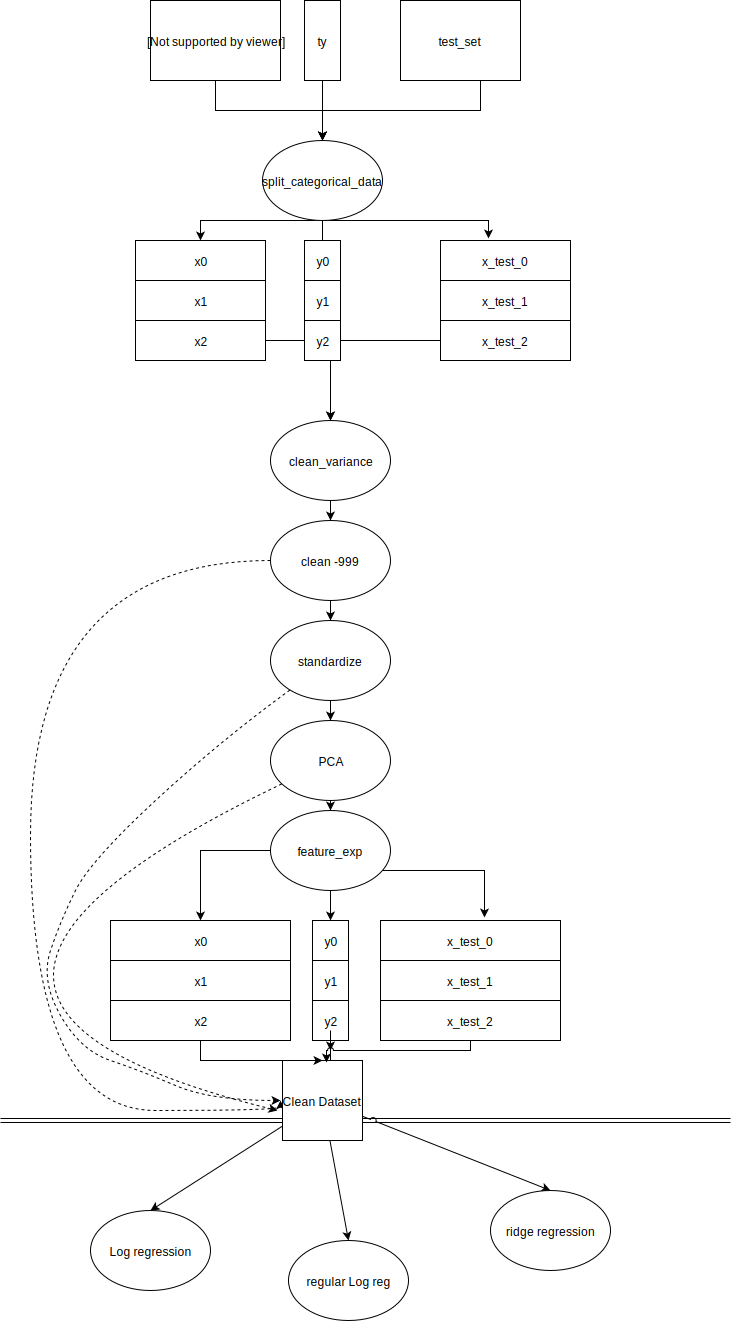

In [15]:
from IPython.core.display import SVG
SVG(filename='pipeline.svg')

## Load the training data into feature matrix, class labels, and event ids:

In [16]:
import logistic as log
import split as spl
import least_squares as lst
import helpers as hlp
import pre_processing as pre

In [17]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
DATA_TEST_PATH = '../data/test.csv'

In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import pandas as pd # cannot use external libraries, just pandas for data exploration

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
y, tX, ids = hlp.load_csv_data(DATA_TRAIN_PATH)
_, tX_test, ids_test = hlp.load_csv_data(DATA_TEST_PATH)

In [20]:
print(tX.shape)
print(y.shape)

(250000, 30)
(250000,)


## Data exploration

In [21]:
data = pd.read_csv(DATA_TRAIN_PATH)
test_data = pd.read_csv(DATA_TEST_PATH)
dic = {'s':1,'b':-1}
data.Prediction = data.Prediction.map(dic)
test_data.Prediction = test_data.Prediction.map(dic)
data.head(10)

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,1,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497
1,100001,-1,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.000,-999.000,46.226
2,100002,-1,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.000,-999.000,44.251
3,100003,-1,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
4,100004,-1,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
5,100005,-1,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,...,2.237,282.849,3,90.547,-2.412,-0.653,56.165,0.224,3.106,193.660
6,100006,1,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,...,-1.443,294.074,2,123.010,0.864,1.450,56.867,0.131,-2.767,179.877
7,100007,1,154.916,10.418,94.714,29.169,-999.000,-999.000,-999.000,2.897,...,-1.761,187.299,1,30.638,-0.715,-1.724,-999.000,-999.000,-999.000,30.638
8,100008,-1,105.594,50.559,100.989,4.288,-999.000,-999.000,-999.000,2.904,...,0.024,129.804,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
9,100009,1,128.053,88.941,69.272,193.392,-999.000,-999.000,-999.000,1.609,...,0.845,294.741,1,167.735,-2.767,-2.514,-999.000,-999.000,-999.000,167.735


In [22]:
mask = data.isin([-999]).any(axis = 1)
print(len(data[mask]))
print(len(data))

181886
250000


_The vast majoriy of our data has -999 values: we'd better handle it carefully_

In [23]:
#data.replace(to_replace = -999,value = np.nan, inplace = True)

In [24]:
#replace_val = np.nan
#tX = np.where(tX == -999,replace_val,tX)

In [25]:
std = np.nanstd(tX,axis = 0)
mean = np.nanmean(tX,axis = 0)

In [26]:
print('Train set size: {} samples x {} features'.format(pd.DataFrame(tX).shape[0], pd.DataFrame(tX).shape[1]))
print('Test set size: {} samples x {} features'.format(test_data.shape[0], pd.DataFrame(tX).shape[1]))

Train set size: 250000 samples x 30 features
Test set size: 568238 samples x 30 features


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 32 columns):
Id                             250000 non-null int64
Prediction                     250000 non-null int64
DER_mass_MMC                   250000 non-null float64
DER_mass_transverse_met_lep    250000 non-null float64
DER_mass_vis                   250000 non-null float64
DER_pt_h                       250000 non-null float64
DER_deltaeta_jet_jet           250000 non-null float64
DER_mass_jet_jet               250000 non-null float64
DER_prodeta_jet_jet            250000 non-null float64
DER_deltar_tau_lep             250000 non-null float64
DER_pt_tot                     250000 non-null float64
DER_sum_pt                     250000 non-null float64
DER_pt_ratio_lep_tau           250000 non-null float64
DER_met_phi_centrality         250000 non-null float64
DER_lep_eta_centrality         250000 non-null float64
PRI_tau_pt                     250000 non-null float64
PRI_tau_eta  

In [28]:
data.describe()

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-0.314664,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,...,-0.010119,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591
std,72168.927986,0.949205,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,...,1.812223,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662
min,100000.000000,-1.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,...,-3.142000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
25%,162499.750000,-1.000000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,...,-1.575000,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
50%,224999.500000,-1.000000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,...,-0.024000,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500
75%,287499.250000,1.000000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,...,1.561000,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750
max,349999.000000,1.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,...,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000


## Data Cleaning

In [29]:
#totrash before submit: we use pandas to know to which index PRI_jet_num does correspond.
np.where(data.columns.values == "PRI_jet_num")

(array([24], dtype=int64),)

In [30]:
x_trains = spl.split_categorical_data(tX,24,labels = y,split = False)
x_test = spl.split_categorical_data(tX_test,24,split = False)

In [31]:
#deso pour cette boucle a la c++ de mords moi le noeud, dois y avoir un moyen de faire ca clean
for i in range(len(x_trains)):
    pre.clean_variance(x_trains[i][0],x_test[i],inplace = True)
    pre.clean_value(x_trains[i][0],-999,np.nan,inplace = True)
    pre.clean_value(x_test[i][0],-999,np.nan,inplace = True)
    x_std,x_mean,_ =  pre.standardize_data(x_trains[i][0], inplace = True)
    pre.standardize_data(x_test[i], x_mean,x_std,inplace = True)
    pre.clean_value(x_trains[i][0],np.nan,0,inplace = True)
    pre.clean_value(x_test[i][0],np.nan,0,inplace = True)
    #todo: pca, feature exp

AttributeError: 'tuple' object has no attribute 'copy'

TODO:At this point todo: in pre_processing.py, all the functions used here basically. especially change the form of standardize data so that it does not make the job of clean_value.


#### Remove zero variance

In [68]:
x_trains = spl.split_categorical_data(tX,22,labels = y,split = True)
x_tests = spl.split_categorical_data(tX_test,22,split = True)

In [69]:
# Sanity check
print('Shape of category 0: {} x {}'.format(x_trains[0][0].shape[0], x_trains[0][0].shape[1]))
print('Shape of category 1: {} x {}'.format(x_trains[1][0].shape[0], x_trains[1][0].shape[1]))
print('Shape of category 2 and 3: {} x {}'.format(x_trains[2][0].shape[0], x_trains[2][0].shape[1]))

print('Total: {}'.format(x_trains[0][0].shape[0] + x_trains[1][0].shape[0] + x_trains[2][0].shape[0]))

Shape of category 0: 99913 x 30
Shape of category 1: 77544 x 30
Shape of category 2 and 3: 72543 x 30
Total: 250000


In [70]:
reduced_x_trains = []
reduced_x_tests = []
for i in range(len(x_trains)):
    tr = x_trains[i][0]
    te = x_tests[i]
    
    x_tr, x_te = pre.clean_variance(tr, te, inplace=False)
    reduced_x_trains.append((x_tr, x_trains[i][1])) # x_trains[i][1] = labels
    reduced_x_tests.append(x_te)

In [71]:
# Sanity check
print('Shape of category 0 (train): {} x {}'.format(reduced_x_trains[0][0].shape[0], reduced_x_trains[0][0].shape[1]))
print('Shape of category 0 (test): {} x {}'.format(reduced_x_tests[0].shape[0], reduced_x_tests[0].shape[1]))

print('Shape of category 1 (train): {} x {}'.format(reduced_x_trains[1][0].shape[0], reduced_x_trains[1][0].shape[1]))
print('Shape of category 1 (test): {} x {}'.format(reduced_x_tests[1].shape[0], reduced_x_tests[1].shape[1]))

print('Shape of category 2 and 3 (train): {} x {}'.format(reduced_x_trains[2][0].shape[0], reduced_x_trains[2][0].shape[1]))
print('Shape of category 2 and 3 (test): {} x {}'.format(reduced_x_tests[2].shape[0], reduced_x_tests[2].shape[1]))


Shape of category 0 (train): 99913 x 18
Shape of category 0 (test): 227458 x 18
Shape of category 1 (train): 77544 x 22
Shape of category 1 (test): 175338 x 22
Shape of category 2 and 3 (train): 72543 x 29
Shape of category 2 and 3 (test): 165442 x 29


In [57]:
# on veut clean les variances nulles dans le train ET dans le test
# we don't care about labels here
#for (tr, te) in zip(x_trains[0], x_test[0]):
#    blablabla

## Data Processing

#### Data standardization

In [76]:
std_train_0, mu_0, sigma_0 = pre.standardize_data(reduced_x_trains[0][0])
std_test_0, mu_0, sigma_0 = pre.standardize_data(reduced_x_tests[0], mu_0, sigma_0)

In [81]:
# Sanity check
print('Shape of category 0 (std train): {} x {}'.format(std_train_0.shape[0], std_train_0.shape[1]))
print('Shape of category 0 (std test): {} x {}'.format(std_test_0.shape[0], std_test_0.shape[1]))

Shape of category 0 (std train): 99913 x 18
Shape of category 0 (std test): 227458 x 18


In [ ]:
#trash random dataframe
np.random.seed(2)
df = pd.DataFrame(np.random.randint(-1002,-995,size =(3,4)), columns=list('ABCD'))
df.replace(to_replace = -999,value = np.nan)

## Put your useful trash here

In [ ]:
#Yann
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)